# Prediciting BitCoin Prices
In this case, we will explore the futile, but valiant effort of predicting BitCoin prices through both an LSTM network, random walks, and FB Prophet

Using a dataset that records daily prices, rather than minute by minute prices, we can avoid noise leading to inconclusive results.

In [3]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
from datetime import timedelta
import numpy as np

# get market info for bitcoin from the start of 2016 to the current day
bitcoin_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
bitcoin_info = bitcoin_info.assign(Date=pd.to_datetime(bitcoin_info['Date']));

#Cleanup dataset when volume is equal to -; asteriks in column names, and volume needs to be an int
bitcoin_info.loc[bitcoin_info['Volume']=="-",'Volume']=0
bitcoin_info.columns = bitcoin_info.columns.str.replace("*",""); #columns is an array of column labels
bitcoin_info['Volume'] = bitcoin_info['Volume'].astype('int64');


bitcoin_info.columns =[bitcoin_info.columns[0]]+['bt_'+i for i in bitcoin_info.columns[1:]] #column names not mutable
bitcoin_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap
0,2019-08-23,10136.31,10442.44,10078.19,10407.97,15627023886,186231409722
1,2019-08-22,10142.52,10233.00,9831.46,10131.06,17097508856,181257125783
2,2019-08-21,10764.57,10798.73,9962.72,10138.05,19473084768,181364502142
3,2019-08-20,10916.35,10947.04,10618.96,10763.23,15053082175,192530283565
4,2019-08-19,10350.28,10916.05,10313.20,10916.05,16038264603,195243306008


Lets Plot the Opening Price over Time

Text(0.5, 1.0, 'Bitcoin Closing Price Over Time')

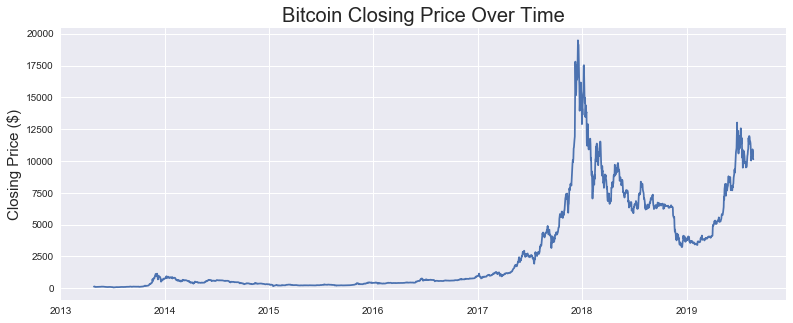

In [4]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(13)
mpl.style.use('seaborn')
#bitcoin_info['Date'].astype(datetime.datetime)
plt.plot(pd.DatetimeIndex(bitcoin_info['Date']).to_pydatetime(),bitcoin_info['bt_Open'])
plt.ylabel('Closing Price ($)',fontsize=15)
plt.title('Bitcoin Closing Price Over Time',fontsize=20)

In [5]:
bitcoin_info_split =bitcoin_info[bitcoin_info['Date']>='2015-01-01']
bitcoin_info = bitcoin_info_split.assign(bt_day_norm_diff = lambda x:(x['bt_Close']- x['bt_Open'])/x['bt_Open'])
bitcoin_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,bt_day_norm_diff
0,2019-08-23,10136.31,10442.44,10078.19,10407.97,15627023886,186231409722,0.026801
1,2019-08-22,10142.52,10233.00,9831.46,10131.06,17097508856,181257125783,-0.001130
2,2019-08-21,10764.57,10798.73,9962.72,10138.05,19473084768,181364502142,-0.058202
3,2019-08-20,10916.35,10947.04,10618.96,10763.23,15053082175,192530283565,-0.014027
4,2019-08-19,10350.28,10916.05,10313.20,10916.05,16038264603,195243306008,0.054662


Let us now mark the data which data the model will be trained on prior and tested on after. Arbitraily, I will pick the 1st of June 2017 as that data.

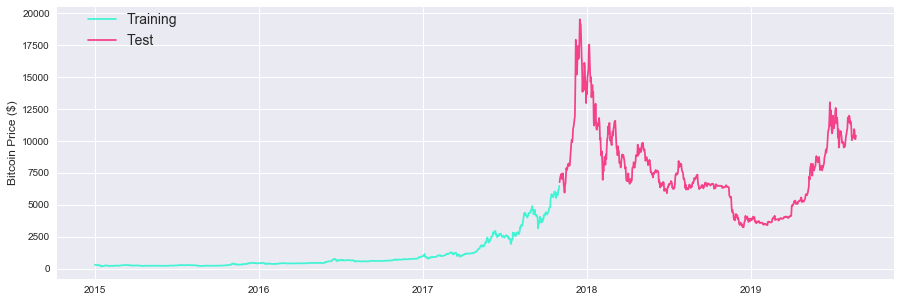

In [6]:
split = '2017-11-01'
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
mpl.style.use('seaborn')
plt.plot(bitcoin_info[bitcoin_info['Date'] < split]['Date'],
         bitcoin_info[bitcoin_info['Date'] < split]['bt_Close'], 
         color='#42f4d4', label='Training')
plt.plot(bitcoin_info[bitcoin_info['Date'] >= split]['Date'],
         bitcoin_info[bitcoin_info['Date'] >= split]['bt_Close'], 
         color='#f44189', label='Test')
plt.ylabel('Bitcoin Price ($)',fontsize=12)
plt.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14});

The simplest walk can be described as a lag model, in other words, today's price will equal yesterday's price. How exciting!

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x26cc65aee48>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x26cc65cac50>)

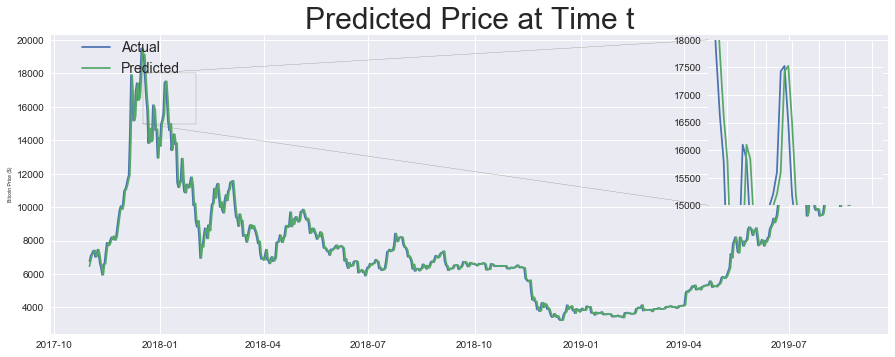

In [7]:
fig, ax = plt.subplots(1,1)
fig.set_figwidth(15)
mpl.style.use('seaborn')
ax.plot(bitcoin_info[bitcoin_info['Date']>=split]['Date'],
        bitcoin_info[bitcoin_info['Date']>=split]['bt_Close'],label='Actual')
current_date = datetime.datetime.strptime(split,'%Y-%m-%d')
ax.plot(bitcoin_info[bitcoin_info['Date']>=split]['Date'],
        bitcoin_info[bitcoin_info['Date']>=current_date-timedelta(days=1)]['bt_Close'][1:],label='Predicted')

ax.set_ylabel('Bitcoin Price ($)',fontsize=20)
ax.set_title('Predicted Price at Time t',fontsize = 30)
plt.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})

#ZOom! This code is from http://akuederle.com/matplotlib-zoomed-up-inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

axins = zoomed_inset_axes(ax, 3.3, loc=1) # zoom-factor: 2.5, location: upper-left
axins.plot(bitcoin_info[bitcoin_info['Date']>=split]['Date'],
        bitcoin_info[bitcoin_info['Date']>=split]['bt_Close'])
current_date = datetime.datetime.strptime(split,'%Y-%m-%d')
axins.plot(bitcoin_info[bitcoin_info['Date']>=split]['Date'],
        bitcoin_info[bitcoin_info['Date']>=current_date-timedelta(days=1)]['bt_Close'][1:])
ax.set_ylabel('Bitcoin Price ($)',fontsize=5)
axins.set_xlim(datetime.date(2017,12,17), datetime.date(2018,2,1)) # apply the x-limits
axins.set_ylim(15000,18000) # apply the y-limits
plt.xticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")

## Random Walks
As we can see, nobody is going to be a billionaire overnight through this method. Instead of mirroring prices, let us try using 
random walks. Except, what is a random walk? For that, let us start with a example I've taken from a PBS Studio Video (https://www.youtube.com/watch?v=stgYW6M5o4k)

Imagine that on flipping a fair coin, a head represents moving foward one spot on the number line while a tail represents moving backward one spot on the number line. We can say that after one flip, you can have either H or T; thus,there is a 1/2 probability of being at 1 and a 1/2 probability of being at -1. In two turns, you can flip either HH, TT, HT or TH; thus there is a 1/4 probability at being -2,1/4 probability being at 2, and 1/2 probability being at 0. In three turns, you can flip either HHH, TTT, HTH, THT, HHT, THH, TTH, HTT; thus there is a 1/8 probability at being -3,3/8 probability being at -1, 3/8 probability being at 1, and 1/8 probability being at 3.

We can enumerate the results for n flips as follows: 

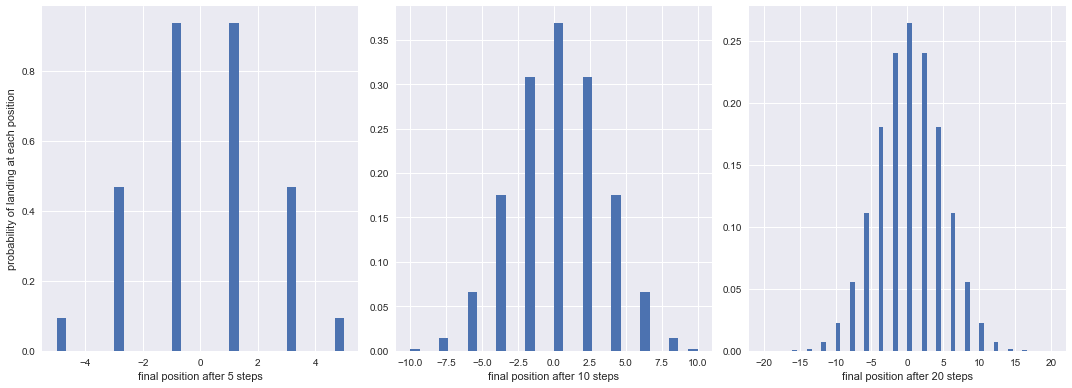

In [8]:
def tosses(N):
    L = [''] 
    for i in range(0,N):
        L=[l+'H' for l in L]+[l+'T' for l in L]
    return L
list=[]
count = 0
def make_freq(N):
    count = 0
    toss_enumeration = tosses(N)
    for combo in toss_enumeration:
        for i in range(len(combo)):
            if combo[i]=='H':
                count+=1
            else:
                count-=1
        list.append(count);
        count = 0;

make_freq(5)
pd_list = pd.Series(list)
list=[]
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.hist(pd_list,bins =30,density = True)
ax1.set_xlabel("final position after 5 steps")
ax1.set_ylabel("probability of landing at each position")

make_freq(10)
pd_list = pd.Series(list)
#list=[]
ax2.hist(pd_list,bins =30,density = True)
ax2.set_xlabel("final position after 10 steps")


make_freq(20)
pd_list = pd.Series(list)
ax3.hist(pd_list,bins = 60,density = True)
ax3.set_xlabel("final position after 20 steps")

fig.set_figwidth(15)
plt.tight_layout()

As you can see after N flips, the probabilites of landing further from 0 get smaller as N increases. In fact, you will land between $-\sqrt{N}$ and $\sqrt{N}$ most of the time.

### Lets Get back to BitCoin now

Therefore, if we treat a quantity such as prices as random walks, then: 
$PredictedPrice_t = ActualPrice_{t-1} * X$~$N(\mu,\sigma)$ where $\mu$ and $\sigma$ are determined from data before the split date

First, we check if the normalized price differences follow a normal distribution.

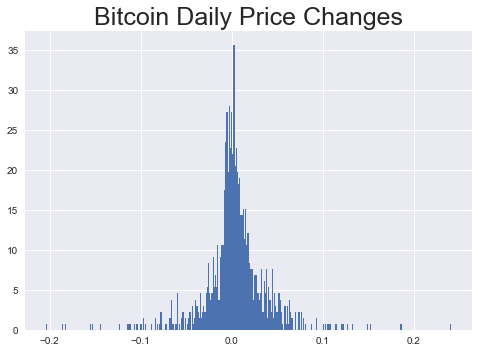

In [9]:
fig, (ax1) = plt.subplots(1,1)

ax1.hist(bitcoin_info[bitcoin_info['Date']< split]['bt_day_norm_diff'], density = True, bins=350)
ax1.set_title('Bitcoin Daily Price Changes',fontsize = 25)
plt.show()

Next, we graph a model based on single-point prediction and multi-pont prediction of the test set. Although the single-point predictions are quite accurate, there is no real prediction power just as we saw with the simple lag model above.
Play with the slider to see how dependent the models are on random seed, especially on the full interval prediction.

In [10]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline
def plt_bt_single(seed):
    np.random.seed(seed)
    bt_walk_mean = np.mean(bitcoin_info[bitcoin_info['Date']<split]['bt_day_norm_diff'])
    bt_walk_std = np.std(bitcoin_info[bitcoin_info['Date']<split]['bt_day_norm_diff'])
    bt_random_steps = np.random.normal(bt_walk_mean, bt_walk_std,
                                       (max(bitcoin_info['Date']).to_pydatetime() - datetime.datetime.strptime(split, '%Y-%m-%d')).days + 1)
    bt_random=[]
    #value is the counter-th representation in bt_random_steps
    #add each closing price*(multiple of value(use training data)) to the bt_random array and 
    # append using the previous days adjusted price to the current day*(1+value)
    for counter, value in enumerate(bt_random_steps):
        if counter==0:
            #set the intial price
            bt_random.append(bitcoin_info[bitcoin_info['Date']< split]['bt_Close'].values[0]*(1+value))
        else:
            bt_random.append(bt_random[counter-1]*(value+1))
            
    fig, (ax1,ax2) =plt.subplots(2,1)
    #graph using test data
    ax1.plot(bitcoin_info[bitcoin_info['Date']>= split]['Date'],
         bitcoin_info[bitcoin_info['Date']>= split]['bt_Close'], label='Actual')
    #add 1 to all random steps
    ax1.plot(bitcoin_info[bitcoin_info['Date']>= split]['Date'],
         bitcoin_info[bitcoin_info['Date'] + datetime.timedelta(days=1)>= split]['bt_Close'][1:] * (1+bt_random_steps), label='Predicted')
    
    ax2.plot(bitcoin_info[bitcoin_info['Date']>= split]['Date'],
         bitcoin_info[bitcoin_info['Date']>= split]['bt_Close'], label='Actual')
    ax2.plot(bitcoin_info[bitcoin_info['Date']>= split]['Date'],
         bt_random[::-1], label='Predicted')
    
    
    #Zoom
    axins = zoomed_inset_axes(ax1, 2.2, loc=1) # zoom-factor: 2.2, location: upper-right
    axins.plot(bitcoin_info[bitcoin_info['Date']>= split]['Date'],
         bitcoin_info[bitcoin_info['Date']>= split]['bt_Close'], label='Actual')
    axins.plot(bitcoin_info[bitcoin_info['Date']>= split]['Date'],
         bitcoin_info[bitcoin_info['Date'] + datetime.timedelta(days=1)>= split]['bt_Close'][1:] * (1+bt_random_steps), label='Predicted')
    axins.set_xlim(datetime.date(2018,2,1), datetime.date(2018,4,1)) # apply the x-limits
    axins.set_ylim(6500,12000) # apply the y-limits
    
    plt.xticks(visible=False)
    plt.yticks(visible=False)
    mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", ec="0.5")

    #somehow figure out a zoom only where collisions occur
    
    
    #Graph stuff
    ax1.set_ylabel('Bitcoin Price ($)',fontsize=20)
    ax1.set_title('Single Point Random Walk',fontsize=30)
    ax2.set_title('Full Interval Random Walk',fontsize=30)
    fig.set_figwidth(15)
    fig.set_figheight(10)
    plt.legend(bbox_to_anchor=(0.03, 1), loc=1, borderaxespad=0., prop={'size': 14})
   
            
    plt.show()
    
interactive_plot = interactive(plt_bt_single, seed=(0,100),continuous_update=False)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=50, description='seed'), Output()), _dom_classes=('widget-interact',))

As we can see from each type of walk, a crucial sticker is that we trained over a period (2014-2016) where the price was relatively stagnant.

# LSTM (Long Short Term Memory)

Let's see if the magic of neural network can offer any real prediction power. 
Past performance always implies future performance, right?

Some new columns we will add are volatility and and a close price/ high price difference.
    Volatility is a very complicated topic [example](https://core.ac.uk/download/pdf/111421957.pdf) with many different definitions including "opening, closing, high and low prices", drift, and other mathmatical models. For our cases, volatility is simply the difference between high and low price divided by the opening price.
    The bt_close_high_diff is the ratio of differences between the closing price and price high as well as price low and price high, but calculated such that 1 equals the daily high and -1 equals the daily low.

Next, we must normalize our data so that no input feature dominates the model.

In [11]:
#following defintion of volatility
bitcoin_info = bitcoin_info.assign(bt_day_volatility = lambda x:(x['bt_High']- x['bt_Low'])/x['bt_Open'])
#
bitcoin_info = bitcoin_info.assign(bt_close_high_diff = lambda x:2*(x['bt_High']- x['bt_Close'])/(x['bt_High']-x['bt_Low'])-1)
#print(bitcoin_info[bitcoin_info['bt_close_high_diff']==1])
bitcoin_info = bitcoin_info.sort_values(by='Date')
bitcoin_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,bt_day_norm_diff,bt_day_volatility,bt_close_high_diff
1695,2015-01-01,320.43,320.43,314.00,314.25,8036550,4297535768,-0.019287,0.020067,0.922240
1694,2015-01-02,314.08,315.84,313.57,315.03,7860650,4309551126,0.003025,0.007227,-0.286344
1693,2015-01-03,314.85,315.15,281.08,281.08,33054400,3846269872,-0.107257,0.108210,1.000000
1692,2015-01-04,281.15,287.23,257.61,264.20,55629100,3616320975,-0.060288,0.105353,0.555030
1691,2015-01-05,265.08,278.34,265.08,274.47,43962800,3758098008,0.035423,0.050023,-0.416290


We purpose pick a neuron to be a collection of 10 days. Whether that is too long a time period for prediction or even too short a time period depends on if you believe the EMH. Furthermore, columns like bt_Market_Cap,bt_day_norm_diff, bt_Open, Date, bt_Low, bt_High are unnescessary now. 

In [12]:
training_set = bitcoin_info[bitcoin_info['Date']<split]
test_set = bitcoin_info[bitcoin_info['Date']>=split]
def drop(set):
    set = set.drop('Date', 1)
    set = set.drop('bt_Open',1)
    set = set.drop('bt_Market Cap', 1)
    set = set.drop('bt_Low', 1)
    set = set.drop('bt_High', 1)
    set = set.drop('bt_day_norm_diff',1)
    return set
training_set = drop(training_set)
test_set = drop(test_set)

training_input_neurons=[]
test_input_neurons=[]
for i in range(len(training_set)-10):
    #every 10th dataframe of the training set
    every_10th_set = training_set[i:(i+10)].copy()
    for col in ['bt_Close','bt_Volume']:
        #normalize!
        every_10th_set.loc[:, col] = every_10th_set[col]/every_10th_set[col].iloc[0] - 1 
    training_input_neurons.append(every_10th_set);
    
for i in range(len(test_set)-10):
    every_10th_set = test_set[i:(i+10)].copy()
    for col in ['bt_Close','bt_Volume']:
        #normalize!
        every_10th_set.loc[:, col] = every_10th_set[col]/every_10th_set[col].iloc[0] - 1
    test_input_neurons.append(every_10th_set)
    
display(training_input_neurons[0])
display(test_input_neurons[0])

,bt_Close,bt_Volume,bt_day_volatility,bt_close_high_diff
1695,0.000000,0.000000,0.020067,0.922240
1694,0.002482,-0.021888,0.007227,-0.286344
1693,-0.105553,3.113009,0.108210,1.000000
1692,-0.159268,5.922013,0.105353,0.555030
1691,-0.126587,4.470357,0.050023,-0.416290
1690,-0.089292,1.892497,0.054077,-0.816835
1689,-0.063357,2.094213,0.054775,-0.437141
1688,-0.098329,1.486453,0.040695,0.802840
1687,-0.075863,1.329184,0.037467,-0.867675
1686,-0.125537,0.899360,0.049286,0.882768


,bt_Close,bt_Volume,bt_day_volatility,bt_close_high_diff
660,0.000000,0.000000,0.060461,-1.000000
659,0.045984,0.621342,0.089795,-0.050854
658,0.065085,0.174036,0.064670,0.106272
657,0.090529,-0.134661,0.064426,-0.510767
656,0.094587,-0.170681,0.038394,0.477857
655,0.037748,0.084165,0.059226,0.929526
654,0.055719,-0.189519,0.032780,-0.053601
653,0.102312,0.603375,0.092755,-0.043690
652,0.055601,0.124004,0.046370,0.756393
651,-0.022043,0.814519,0.121991,0.585730


Every index of the training_set represents what the model will train on, with the above characteristics.

In [13]:
training_input_neurons = [np.array(training_input_neuron) for training_input_neuron in training_input_neurons]
training_input_neurons = np.array(training_input_neurons)

test_input_neurons = [np.array(test_input_neuron) for test_input_neuron in test_input_neurons]
test_input_neurons = np.array(test_input_neurons)
#need .values(so index not included in result) or it will NaN
training_outputs = (training_set['bt_Close'][10:].values/training_set['bt_Close'][:-10].values)-1
test_outputs = (test_set['bt_Close'][10:].values/test_set['bt_Close'][:-10].values)-1

In [14]:
#display(training_outputs)

[What is Dropout](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/)

In [15]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
def LSTM_model(data, output_size, neurons):
    #if we didn't already have the test and training data split up, scikit has a cool train_test_split function
    model = Sequential()
    model.add(LSTM(neurons,input_shape=(data.shape[1],data.shape[2])))
    #activation of 'downstream' neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.
    model.add(Dropout(.25))
    model.add(Dense(units=1))
    model.add(Activation("linear"))
    model.compile(loss="mae", optimizer="adam")
    return model


Using TensorFlow backend.


In [16]:
bt_model = LSTM_model(training_input_neurons,1,20)
#train, finally!!!
# Stochastic Batch Gradient Descent????
bt_error_epoch = bt_model.fit(training_input_neurons,training_outputs,epochs=50, batch_size=1,verbose=2,shuffle=True)

Epoch 1/50
 - 5s - loss: 0.0512
Epoch 2/50
 - 4s - loss: 0.0385
Epoch 3/50
 - 4s - loss: 0.0343
Epoch 4/50
 - 4s - loss: 0.0320
Epoch 5/50
 - 4s - loss: 0.0311
Epoch 6/50
 - 4s - loss: 0.0293
Epoch 7/50
 - 4s - loss: 0.0295
Epoch 8/50
 - 4s - loss: 0.0287
Epoch 9/50
 - 4s - loss: 0.0279
Epoch 10/50
 - 4s - loss: 0.0279
Epoch 11/50
 - 4s - loss: 0.0279
Epoch 12/50
 - 4s - loss: 0.0276
Epoch 13/50
 - 4s - loss: 0.0279
Epoch 14/50
 - 4s - loss: 0.0276
Epoch 15/50
 - 4s - loss: 0.0273
Epoch 16/50
 - 4s - loss: 0.0272
Epoch 17/50
 - 4s - loss: 0.0275
Epoch 18/50
 - 4s - loss: 0.0263
Epoch 19/50
 - 4s - loss: 0.0264
Epoch 20/50
 - 4s - loss: 0.0269
Epoch 21/50
 - 4s - loss: 0.0264
Epoch 22/50
 - 4s - loss: 0.0273
Epoch 23/50
 - 4s - loss: 0.0266
Epoch 24/50
 - 4s - loss: 0.0265
Epoch 25/50
 - 4s - loss: 0.0261
Epoch 26/50
 - 4s - loss: 0.0263
Epoch 27/50
 - 4s - loss: 0.0267
Epoch 28/50
 - 4s - loss: 0.0272
Epoch 29/50
 - 4s - loss: 0.0268
Epoch 30/50
 - 4s - loss: 0.0263
Epoch 31/50
 - 4s -

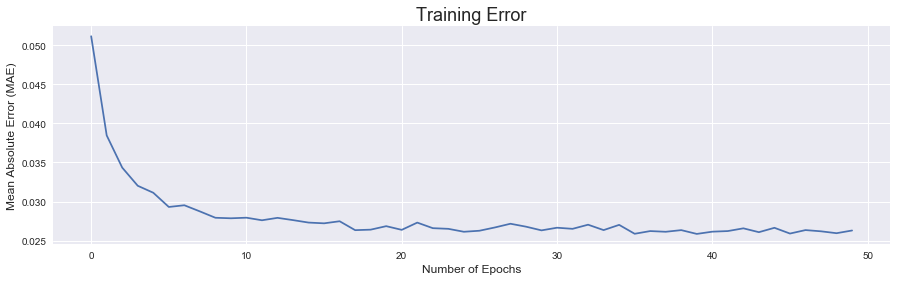

In [17]:
fig, ax1 = plt.subplots(1,1)
fig.set_figwidth(15)
ax1.plot(bt_error_epoch.epoch, bt_error_epoch.history['loss'])
ax1.set_title('Training Error', fontsize = 18)

ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)

ax1.set_xlabel('Number of Epochs',fontsize=12)
plt.show()

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x26cce0ff320>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x26cce108e48>)

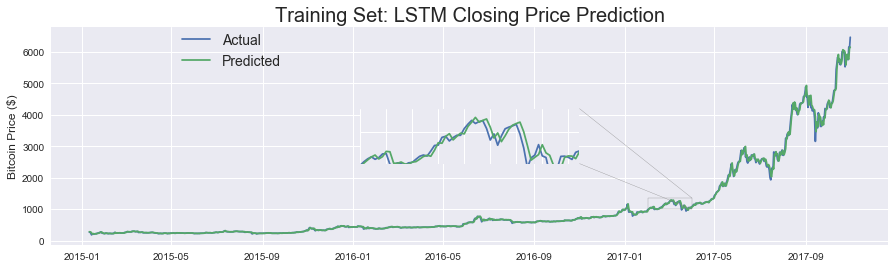

In [18]:
fig, ax1 = plt.subplots(1,1)
fig.set_figwidth(15)
#1392 rows as of 10/24
ax1.plot(bitcoin_info[bitcoin_info['Date']< split]['Date'][10:],
         training_set['bt_Close'][10:], label='Actual')
#prediction will give normalized closing prices, so have to 'undo' that from operation calculating training outputs
#remeber that [:-10] was needed because last 10 not needed
#need [0] because transpose will give you an array of arrays
#display((((np.transpose(bt_model.predict(training_input_neurons))+1)* training_set['bt_Close'].values[:-10])))
ax1.plot(bitcoin_info[bitcoin_info['Date']< split]['Date'][10:],
         ((np.transpose(bt_model.predict(training_input_neurons))+1)* training_set['bt_Close'].values[:-10])[0], label='Predicted')
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.set_title('Training Set: LSTM Closing Price Prediction',fontsize=20)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)

axins = zoomed_inset_axes(ax1, 5, loc=10)
axins.plot(bitcoin_info[bitcoin_info['Date']< split]['Date'][10:],
         training_set['bt_Close'][10:], label='Actual')
axins.plot(bitcoin_info[bitcoin_info['Date']< split]['Date'][10:],
         ((np.transpose(bt_model.predict(training_input_neurons))+1)* training_set['bt_Close'].values[:-10])[0], label='Predicted')

axins.set_xlim(datetime.date(2017,2,1), datetime.date(2017,4,1)) # apply the x-limits
axins.set_ylim(1000,1350) # apply the y-limits
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax1, axins, loc1=1, loc2=4, fc="none", ec="0.5")

Knowing that we've seen graphs of predictions closely mirroing the actual results, we should be wary of this result. This is the result for the training set...we could have overfit our data(hopefully Dropout lessened this impact). Let's see if we did by inputting the test data into our model!

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x26cce1cce80>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x26cce1dc940>)

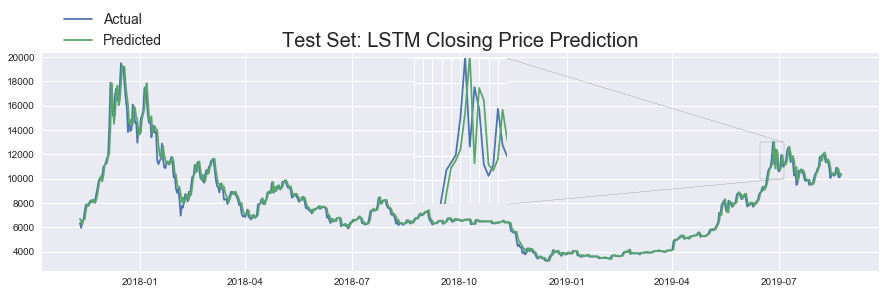

In [19]:
fig, ax1 = plt.subplots(1,1)
fig.set_figwidth(15)
ax1.plot(bitcoin_info[bitcoin_info['Date']>= split]['Date'][10:],
         test_set['bt_Close'][10:], label='Actual')
ax1.plot(bitcoin_info[bitcoin_info['Date']>= split]['Date'][10:],
         ((np.transpose(bt_model.predict(test_input_neurons))+1)* test_set['bt_Close'].values[:-10])[0], label='Predicted')
ax1.legend(bbox_to_anchor=(0.15, 1), loc=4, borderaxespad=0., prop={'size': 14})

ax1.set_title('Test Set: LSTM Closing Price Prediction',fontsize=20)
axins = zoomed_inset_axes(ax1, 4, loc=9)
axins.plot(bitcoin_info[bitcoin_info['Date']>= split]['Date'][10:],
         test_set['bt_Close'][10:], label='Actual')
axins.plot(bitcoin_info[bitcoin_info['Date']>= split]['Date'][10:],
         ((np.transpose(bt_model.predict(test_input_neurons))+1)* test_set['bt_Close'].values[:-10])[0], label='Predicted')
axins.set_xlim(datetime.date(2019,6,15), datetime.date(2019,7,5)) # apply the x-limits
axins.set_ylim(10000,13000) # apply the y-limits
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax1, axins, loc1=1, loc2=4, fc="none", ec="0.5")

For a single point prediction where each price is normalized to every 10th closing price, the model performs quite well,but the prediction is nearly always above the actual price.. Furthermore, similar to random walks, the model is sensitive to random seed. 

Just as we did with the random walk, a full interval prediction can be modeled where the next $n$ prices are normalized to every 10th closing price. //TODO

And now we can even calculate error between the two diffrent methods of prediction.Error is the positive difference between the actual and predicted closing prices.

In [20]:
#will take forever...
#for seed in range(990,1000):
#     np.random.seed(seed)
#     model = LSTM_model(training_input_neurons, 1, 20)
#      model.fit(training_input_neurons,
#                   (training_set['bt_Close'][10:].values/training_set['bt_Close'][:-10].values)-1,
#                   epochs=50, batch_size=1, verbose=0, shuffle=True)
#      model.save('bt_model_randseed_%d.h5'%seed)

In [21]:
from keras.models import load_model
bt_error_LSTM = []

for seed in range(990,999):
    model = load_model('bt_model_randseed_%d.h5'%seed)
    bt_error_LSTM.append(np.mean(abs(np.transpose(model.predict(test_input_neurons))-
                (test_set['bt_Close'].values[10:]/test_set['bt_Close'].values[:-10]-1))))

In [22]:
bt_error_randomWalks = []
bt_walk_mean = np.mean(bitcoin_info[bitcoin_info['Date']<split]['bt_day_norm_diff'])
bt_walk_std = np.std(bitcoin_info[bitcoin_info['Date']<split]['bt_day_norm_diff'])
for seed in range(990,999):
    np.random.seed(seed)
    bt_error_randomWalks.append(np.mean(np.abs((np.random.normal(bt_walk_mean, bt_walk_std, len(test_set)-10)+1)-
                                       (np.array(test_set['bt_Close'][10:])/np.array(test_set['bt_Close'][:-10])))))
                                

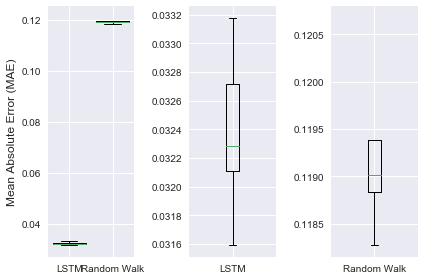

In [23]:
#print(bt_error_LSTM)
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.boxplot([bt_error_LSTM,bt_error_randomWalks],widths=0.75)
ax2.boxplot([bt_error_LSTM])
ax3.boxplot([bt_error_randomWalks])

ax1.set_xticklabels(['LSTM', 'Random Walk'])
ax2.set_xticklabels(['LSTM'])
ax3.set_xticklabels(['Random Walk'])
ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
plt.tight_layout()

It definitely seems like the effort was worth it as the MAE is strikingly lower for the LSTM model than the random walk.

Even with such little error, how does it impact a optimal trading strategy of unlimited trades?

### Return

In [75]:
buy_orders = []
sell_orders = []
#find peaks and valleys
def maxProfit(dates,pred_prices,actual_prices):
    #print(pred_price)
    profit = 0
    actualProfit = 0
    peak = 0
    actualPeak = 0
    valley = 0
    actualValley = 0
    i = 0
    while(i < len(pred_prices) - 1):
        while(i < len(pred_prices) -1 and pred_prices[i]>=pred_prices[i+1]):
            i+=1
        valley = pred_prices[i]
        actualValley = actual_prices[i]
        buy_orders.append([dates[i],valley,actualValley])
        while(i < len(pred_prices) - 1 and pred_prices[i]<=pred_prices[i+1]):
            i+=1
        peak = pred_prices[i]
        actualPeak = actual_prices[i]
        sell_orders.append([dates[i],peak,actualPeak])
        profit+=peak-valley
        actualProfit+=actualPeak-actualValley
    return [profit,actualProfit]


#because the last date in dates is at index 0, we need to match corr. price and date
dates = bitcoin_info[bitcoin_info['Date']>= split]['Date'][10:]
dates.index = dates.index[::-1]

actual_price = test_set['bt_Close'][10:]

actual_price.index = actual_price.index[::-1] 

pred_price = ((np.transpose(bt_model.predict(test_input_neurons))+1)* test_set['bt_Close'].values[:-10])[0]

print ("Predicted Profit: ${}".format(round(maxProfit(dates,pred_price,actual_price)[0],2)))
print ("Actual Profit: ${}".format(round(maxProfit(dates,pred_price,actual_price)[1],2)))
df_buy_orders = pd.DataFrame(buy_orders[:-1], columns = ['Buy Date','Predicted Price','Actual Price']);
df_sell_orders = pd.DataFrame(sell_orders[:-1], columns = ['Sell Date','Predicted Price','Actual Price'])
display(df_buy_orders.tail())
display(df_sell_orders.tail())


Predicted Profit: $82712.7
Actual Profit: $15466.22


,Buy Date,Predicted Price,Actual Price
318,2019-07-30,9523.966888,9607.42
319,2019-08-07,11493.370097,11941.97
320,2019-08-11,11334.938956,11523.58
321,2019-08-15,10326.666751,10311.55
322,2019-08-18,10297.259591,10345.81


,Sell Date,Predicted Price,Actual Price
318,2019-08-06,11863.975104,11478.17
319,2019-08-09,12162.857742,11862.94
320,2019-08-12,11595.878280,11382.62
321,2019-08-17,10464.756582,10231.74
322,2019-08-20,10883.449066,10763.23


# Did we meet our objective?
LSTM is cool and all, but what other models can we use for time-series and what can we conclude from the above?

To answer the first question, we could try using Facebook's Prophet Algorithm or even something much simpler like an Autoregressive(AR) model. Finding other hyperparameters to tune as well, other loss functions more suited to time-series analysis, and better data could be foray of its own.

For example, what if the input vectors also consisted of sentiment analysis for bitcoin-related terms regarding bitcoin or even companies stock whose products are crucial to mining Bitcoin! 

### TODO Integrate other stocks as additional regressors

# FB Prophet

Time series forecasting is a method of prediction used in several buisness applications. Understanding the theory behind the many variations of it is an ongoing process for me, but thankfully the data science team at Facebook has done the heavy lifting for us. I want to experiment with two ways of using this library.

## 1. Using seasonalites and additional regressors

In [89]:
import pandas as pd
import time
import numpy as np
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from datetime import datetime
# get market info for bitcoin from the start of 2016 to the current day
bitcoin_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
bitcoin_info = bitcoin_info.assign(Date=pd.to_datetime(bitcoin_info['Date']));

#Cleanup dataset when volume is equal to -; asteriks in column names, and volume needs to be an int
bitcoin_info.loc[bitcoin_info['Volume']=="-",'Volume']=0
bitcoin_info.columns = bitcoin_info.columns.str.replace("*",""); #columns is an array of column labels
bitcoin_info['Volume'] = bitcoin_info['Volume'].astype('int64');


#split into training and testing dataset
split_date = '2019-08-01'
bitcoin_info.columns =[bitcoin_info.columns[0]]+['bt_'+i for i in bitcoin_info.columns[1:]] #column names not mutable
bitcoin_info_train = bitcoin_info[bitcoin_info['Date']>='2015-01-01']
bitcoin_info_train = bitcoin_info_train[bitcoin_info_train['Date']<split_date]
bitcoin_info_test = bitcoin_info[bitcoin_info['Date']>=split_date]

#create a df that prophet will accept
df_train = bitcoin_info_train[['Date','bt_Close']].copy()
df_train.columns = ['ds','y']
df_train.reset_index()


df_test = bitcoin_info_test[['Date','bt_Close']].copy()
df_test.columns = ['ds','y']
display(df_test.tail())

,ds,y
18,2019-08-05,11805.65
19,2019-08-04,10970.18
20,2019-08-03,10821.73
21,2019-08-02,10518.17
22,2019-08-01,10399.67


After putting our data in the required format (ds and y) and splitting into training and testing data for Prophet, our next step should be to adjust the hyperparameters.
As we adjust out hyperparameters, we should check if our model becomes more or less accurate by looking at MAPE. Honestly, I found it to be more of an 'art' than a science.



## Growth

We do not choose a logistic growth trend model because there is no carrying capacity, or maximum achievable point, for closing price. We will stick to the default linear model. The only issue is that Prophet will predict negative prices or be wilidy inaccurate if the forecast id too far in the future.

## Seasonality

Prophet's prediction is a "decomposable time series model with 3 main componenents: trend, seasonality, holidays" such that 
$y(t) = g(t) + s(t) + h(t) + \epsilon $

This seasonality component can be adjusted in a big way with the either additive or multiplicative seasonality modes. An additive seasonality mode would imply that your seasonality trend should be constant each period of time. A multiplicative seasonality mode would imply the trend becomes more important over time (like the growth of a city, where infrastructure set up in later years lends itself to faster population growth). As crypto becomes more mainstream, this would hold and why I chose multiplicative. 

Surprisingly, Additive mode adds about 10% to the MAPE, but increases returns. I take this as luck.

We should think about seasonalities in people buying crytpo. I am going to assume a relation between stocks and crypto transactional habits. Therefore, the Friday Effect is an additional regressor I will add to. 

Larger Fourier Orders and prior scales will generalize the model: i.e. the model might overfit, learning the noise (rather than the signal) in the training data, but giving poor results when applied to yet unseen data (the test data)


### Instantiate and Fit

In [77]:

def friday_effect(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 4 or date.weekday() == 0:
        return 1
    else:
        return 0
df_train['friday_effect'] = df_train['ds'].apply(friday_effect)
#df_train['cap'] = 15000
m = Prophet(growth='linear',seasonality_mode='multiplicative',
            daily_seasonality=False,
            weekly_seasonality=False,
            yearly_seasonality=False,
            ).add_seasonality(
                    name = 'quarterly',
                    period = 93.3125,
                    fourier_order = 15
            ).add_seasonality(
                    name = 'yearly',
                    period = 365.25,
                    fourier_order = 15
            ).add_seasonality(
                    name = 'Weekly',
                    period = 7,
                    fourier_order = 25
            )
m.add_regressor('friday_effect') # adding this regressor lowered MAPE 
m.fit(df_train)


future = m.make_future_dataframe(periods=len(df_test))
#future['cap'] = 20000
future['friday_effect'] = future['ds'].apply(friday_effect)
display(future[future['friday_effect']==1].tail())

,ds,friday_effect
1681,2019-08-09,1
1684,2019-08-12,1
1688,2019-08-16,1
1691,2019-08-19,1
1695,2019-08-23,1


### Forecast 

In [78]:
def calculateMAPE(y_true,y_pred):
    y_true,y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/ y_true)) * 100

forecast = m.predict(future)

### Cross-Validate

In [80]:
cv_results = cross_validation(m,initial= '1550 days', horizon = '5 days',period = '15 days')

INFO:fbprophet:Making 8 forecasts with cutoffs between 2019-04-12 00:00:00 and 2019-07-26 00:00:00


In [81]:
print('MAPE:',calculateMAPE(cv_results['y'],cv_results['yhat']))
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
display(cv_results)

MAPE: 16.15156848745979


,ds,yhat,yhat_lower,yhat_upper
1691,2019-08-19,8578.729717,7898.168389,9233.965251
1692,2019-08-20,8549.226016,7910.557534,9245.482099
1693,2019-08-21,8587.976517,7933.239055,9266.215317
1694,2019-08-22,8604.080492,7984.709100,9296.972565
1695,2019-08-23,8596.035213,7906.405183,9301.744020


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-04-13,5645.507055,5283.394855,6016.670430,5096.59,2019-04-12
1,2019-04-14,5834.425063,5475.301734,6184.600298,5167.72,2019-04-12
2,2019-04-15,6075.109421,5697.560212,6453.246778,5067.11,2019-04-12
3,2019-04-16,6311.394569,5944.809633,6700.384664,5235.56,2019-04-12
4,2019-04-17,6491.379082,6130.242627,6858.821190,5251.94,2019-04-12
5,2019-04-28,6106.449967,5679.888803,6538.035308,5285.14,2019-04-27
6,2019-04-29,6240.002911,5835.178154,6707.180496,5247.35,2019-04-27
7,2019-04-30,6438.167799,6000.999489,6853.859217,5350.73,2019-04-27
8,2019-05-01,6631.381431,6195.436294,7083.797863,5402.70,2019-04-27
9,2019-05-02,6752.370998,6301.685357,7199.218061,5505.28,2019-04-27


,horizon,mse,rmse,mae,mape,coverage
0,1 days,1.069735e+06,1034.279725,879.257486,0.115386,0.250
1,2 days,1.356845e+06,1164.836777,1049.275381,0.134881,0.125
2,3 days,1.996648e+06,1413.027827,1269.202485,0.164124,0.125
3,4 days,2.356823e+06,1535.194819,1448.279557,0.182671,0.000
4,5 days,3.370368e+06,1835.856183,1671.842071,0.210517,0.125


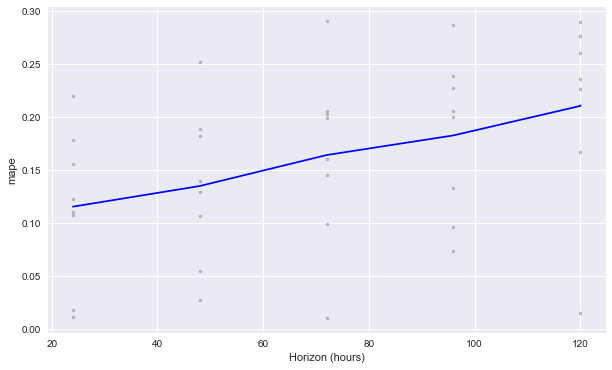

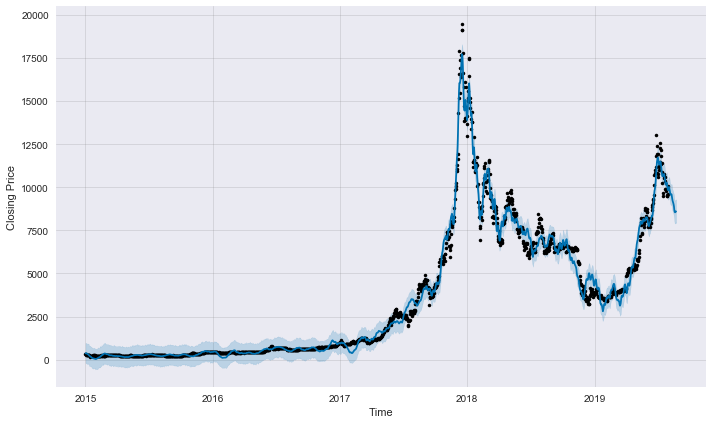

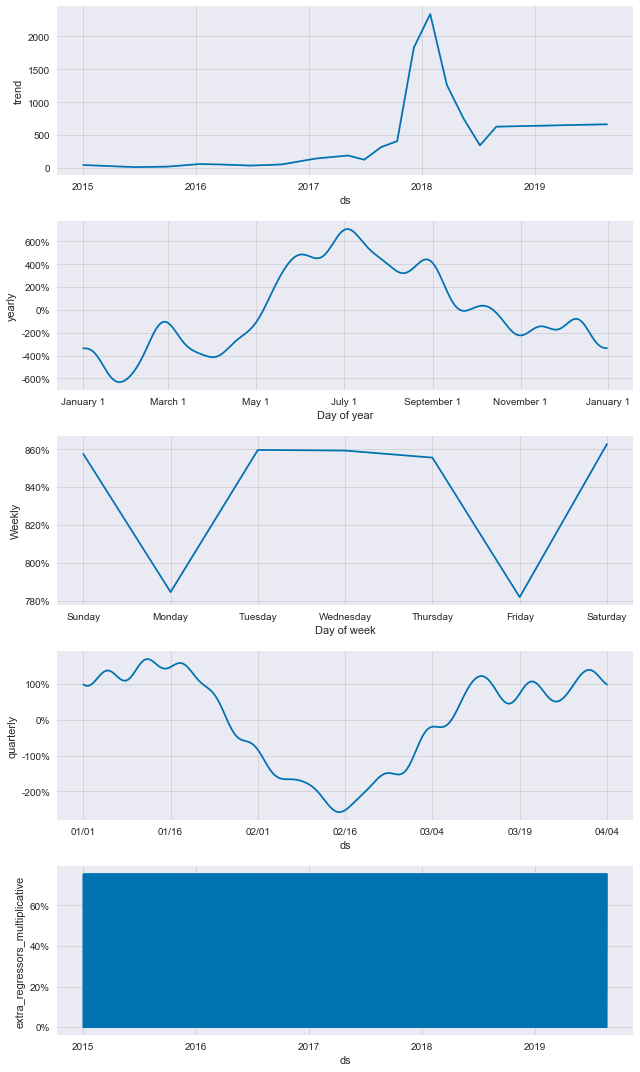

In [82]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(cv_results)
display(df_p)

from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(cv_results, metric='mape')
fig1 = m.plot(forecast,xlabel='Time',ylabel='Closing Price')
fig2 = m.plot_components(forecast)

The black dots are what the model trained on. The blue line is the forecast(prediction). The shaded area is the uncertainity interval. 

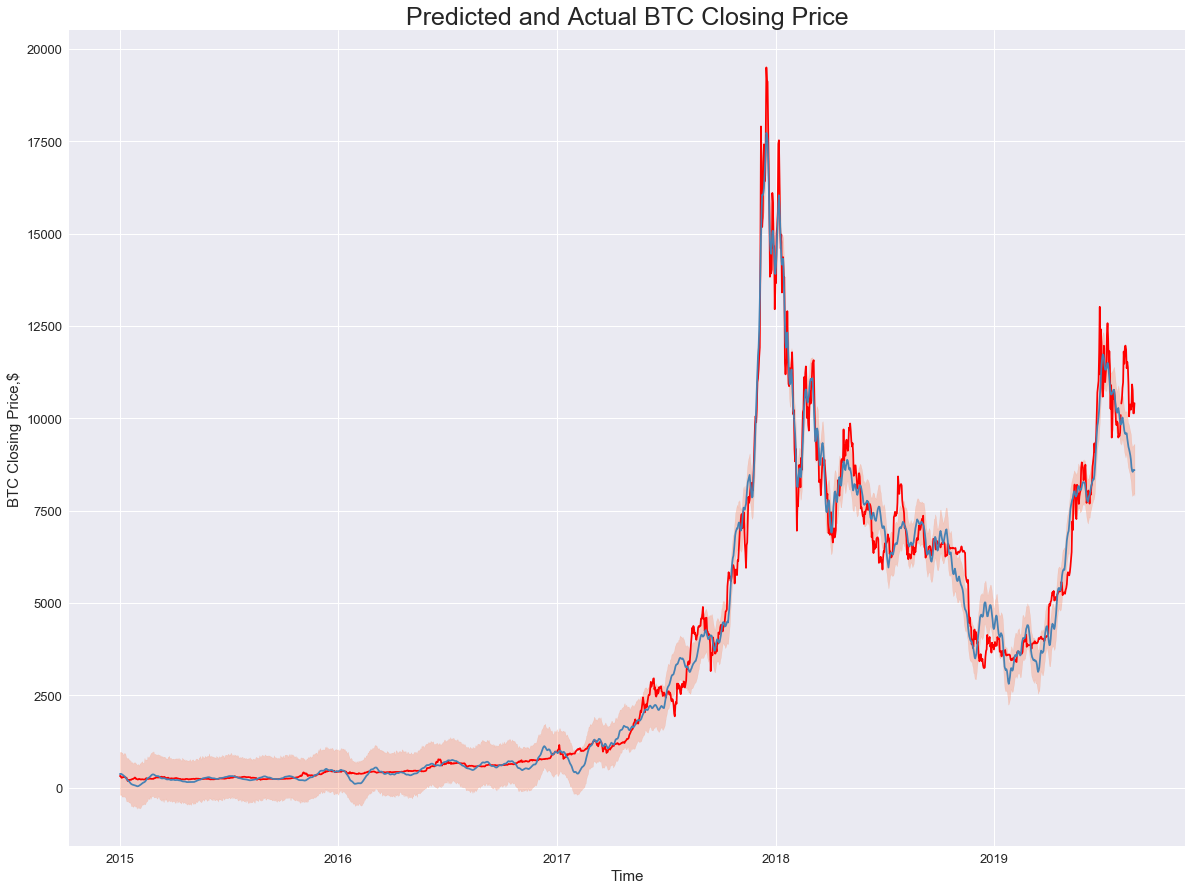

In [107]:
fig, ax1 = plt.subplots(figsize=(20,15))
ax1.plot(forecast[forecast['ds']<split_date]['ds'],df_train['y'][::-1],color='r',label = 'actual')
ax1.plot(forecast[forecast['ds']<split_date]['ds'],forecast[forecast['ds']<split_date]['yhat'],color='steelblue',label='predicted')
ax1.fill_between(forecast[forecast['ds']<split_date]['ds'], forecast[forecast['ds']<split_date]['yhat_lower'], forecast[forecast['ds']<split_date]['yhat_upper'], color='coral', alpha=0.3)


ax1.plot(forecast[forecast['ds']>=split_date]['ds'],df_test['y'][::-1],color='r',label = 'actual')
ax1.plot(forecast[forecast['ds']>=split_date]['ds'],forecast[forecast['ds']>=split_date]['yhat'],color='steelblue',label='predicted')
ax1.fill_between(forecast[forecast['ds']>=split_date]['ds'], forecast[forecast['ds']>=split_date]['yhat_lower'], forecast[forecast['ds']>=split_date]['yhat_upper'], color='coral', alpha=0.3)

ax1.set_title('Predicted and Actual BTC Closing Price',fontsize = 25)
ax1.set_ylabel('BTC Closing Price,$',fontsize=15)
ax1.set_xlabel('Time',fontsize=15)
[l.set_fontsize(13) for l in ax1.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax1.yaxis.get_ticklabels()];

We can measure the disparity in the year 2019 more clearly with residuals.

Text(0.05, 0.85, 'Skewness = -0.03\nMean = -15.32')

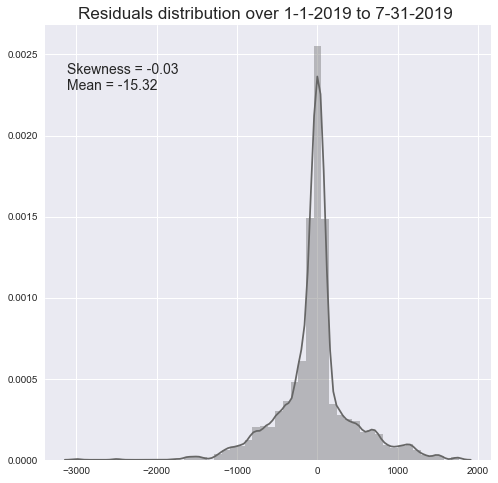

In [104]:
from scipy.stats import skew
fig, ax = plt.subplots(figsize=(8,8))
predicted = forecast[forecast['ds']>='2019-01-01']['yhat']
predicted = np.array(forecast[forecast['ds']<'2019-08-01']['yhat'])
expected = np.array(df_train['y'][::-1]) #reversed because first row starts from day before split
residuals = predicted - expected

sns.distplot(residuals, ax=ax, color='0.4')
ax.set_title('Residuals distribution over 1-1-2019 to 7-31-2019 ', fontsize=17)
ax.text(0.05, 0.85, "Skewness = {:+4.2f}\nMean = {:+4.2f}".\
        format(skew(residuals), residuals.mean()), \
        fontsize=14, transform=ax.transAxes)

### Generate Return 
We will assume we buy or sell as many times as want and only during the days we have cross-validated for. This means we only execute buy sells in short time periods as the model is unable to predict more than 15 days without serious error.

In [86]:
buy_orders = []
sell_orders = []
#find peaks and valleys
def maxProfit(dates,pred_prices,actual_prices):
    profit = 0
    actualProfit = 0
    peak = 0
    actualPeak = 0
    valley = 0
    actualValley = 0
    i = 0
    while(i < len(pred_prices) - 1):
        while(i < len(pred_prices) -1 and pred_prices[i]>=pred_prices[i+1]):
            i+=1
        valley = pred_prices[i]
        actualValley = actual_prices[i]
        buy_orders.append([dates[i],valley,actual_prices[i]])
        while(i < len(pred_prices) - 1 and pred_prices[i]<=pred_prices[i+1]):
            i+=1
        peak = pred_prices[i]
        actualPeak = actual_prices[i]
        sell_orders.append([dates[i],peak,actual_prices[i]])
        profit+=peak-valley
        actualProfit+=actualPeak-actualValley
    return [profit,actualProfit]


dates =  np.array(cv_results['ds'])
pred_prices = np.array(cv_results['yhat'])
actual_prices = np.array(cv_results['y'])


print ("Predicted Profit: {}".format(round(maxProfit(dates,pred_prices,actual_prices)[0],2)))
print ("Actual Profit: {}".format(round(maxProfit(dates,pred_prices,actual_prices)[1],2)))
df_buy_orders = pd.DataFrame(buy_orders[:-1], columns = ['Buy Date','Predicted Price','Actual Price']);
df_sell_orders = pd.DataFrame(sell_orders[:-1], columns = ['Sell Date','Predicted Price','Actual Price'])
display(df_buy_orders)
display(df_sell_orders)



Predicted Profit: 10120.8
Actual Profit: 583.68


,Buy Date,Predicted Price,Actual Price
0,2019-04-13,5645.507055,5096.59
1,2019-04-28,6106.449967,5285.14
2,2019-05-17,5428.258294,7343.90
3,2019-06-01,6750.661817,8564.02
4,2019-06-16,6503.549428,8994.49
5,2019-07-12,11680.558952,11815.99
6,2019-07-31,10235.091746,10085.63
7,2019-04-13,5645.507055,5096.59
8,2019-04-28,6106.449967,5285.14
9,2019-05-17,5428.258294,7343.90


,Sell Date,Predicted Price,Actual Price
0,2019-04-17,6491.379082,5251.94
1,2019-05-02,6752.370998,5505.28
2,2019-05-28,7165.997954,8719.96
3,2019-06-12,7246.465582,8145.86
4,2019-07-01,12354.358329,10583.13
5,2019-07-16,12225.215953,9477.64
6,2019-07-31,10235.091746,10085.63
7,2019-04-17,6491.379082,5251.94
8,2019-05-02,6752.370998,5505.28
9,2019-05-28,7165.997954,8719.96


## 2. Custom N-Cycle TODO

We will use FB Prophet again, but instead of letting Prophet use seasonalities, we will experimently find the lowest MAPE for a n cycle.

0      -0.157741
1      -0.141010
2      -0.123864
3      -0.107761
4      -0.093854
5      -0.082820
6      -0.074757
7      -0.069181
8      -0.065113
9      -0.061243
10     -0.056138
11     -0.048468
12     -0.037209
13     -0.021787
14     -0.002149
15      0.021245
16      0.047511
17      0.075486
18      0.103908
19      0.131581
20      0.157528
21      0.181074
22      0.201873
23      0.219863
24      0.235174
25      0.248006
26      0.258500
27      0.266642
28      0.272205
29      0.274765
          ...   
1665    0.021245
1666    0.047511
1667    0.075486
1668    0.103908
1669    0.131581
1670    0.157528
1671    0.181074
1672    0.201873
1673    0.219863
1674    0.235174
1675    0.248006
1676    0.258500
1677    0.266642
1678    0.272205
1679    0.274765
1680    0.273767
1681    0.268651
1682    0.259003
1683    0.244706
1684    0.226071
1685    0.203901
1686    0.179487
1687    0.154529
1688    0.130973
1689    0.110804
1690    0.095810
1691    0.087354
1692    0.0861

Return per cycle: 0.47
MAPE: 62.8776


[0.4684823870390023, 62.877610084482406]

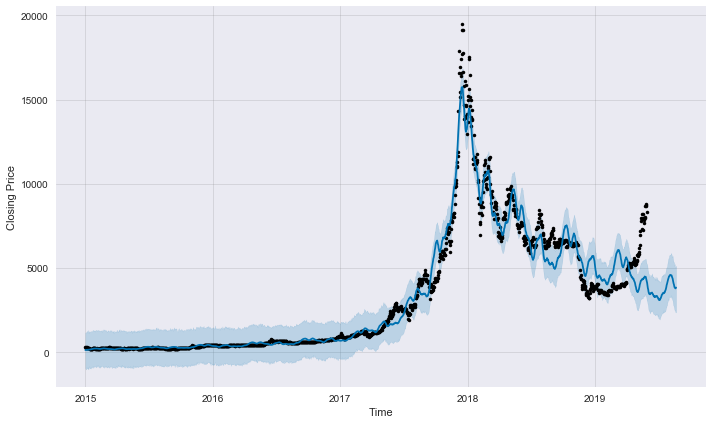

In [152]:
df = bitcoin_info[['Date','bt_Close']].copy()
df.columns = ['ds','y']

df['friday_effect'] = df['ds'].apply(friday_effect)
#for a cycle of length n days, construct a prophet model and its error
def generateReportForCycle(df,n,split_date,debug=False):
    training = df[df['ds']<split_date]
    testing = df[df['ds']>=split_date]
    
    m = Prophet(growth='linear',seasonality_mode='multiplicative',
            daily_seasonality=False,
            weekly_seasonality=False,
            yearly_seasonality=False,
            ).add_seasonality(
                    name = 'custom',
                    period = n,
                    fourier_order = 10
            )
    m.add_regressor('friday_effect')
    m.fit(training)
    future = m.make_future_dataframe(periods=len(testing))
    future['friday_effect'] = future['ds'].apply(friday_effect)
    forecast = m.predict(future)
   
    #display(forecast.custom)
    
    display(forecast.custom)
    return_per_cycle = max(forecast.custom)-min(forecast.custom);
    MAPE = calculateMAPE(testing['y'],forecast[forecast['ds']>=split_date]['yhat'])
    if debug:
        print ("Return per cycle: {}".format(round(return_per_cycle,2)))
        print ( "MAPE: {}".format(round(MAPE,4)))
        fig1 = m.plot(forecast,xlabel='Time',ylabel='Closing Price')
    return [return_per_cycle,MAPE]

generateReportForCycle(df,150,'2019-5-31',True)

Now, we experimently determine the min MAPE with acceptable gain with Cycle Lengths 10-365

Text(0.5, 1.0, 'MAPE for a given cycle length')

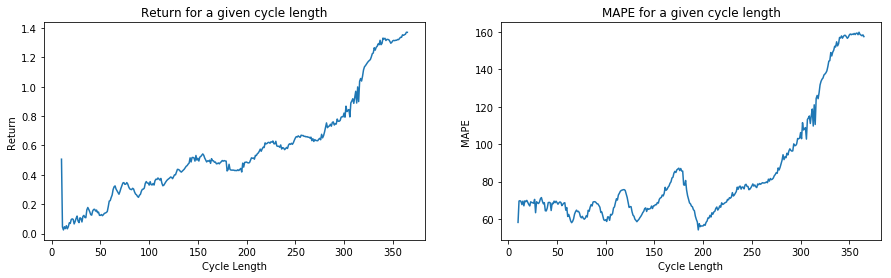

In [35]:
N = range(10,366)
returns = [];
errors = [];

#takes a really long time
for n in N:
    cycle = generateReportForCycle(df,n,'2019-5-31')
    returns.append(cycle[0])
    errors.append(cycle[1])
    
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figwidth(15)
ax1.plot(N,returns)
ax1.set_xlabel("Cycle Length")
ax1.set_ylabel("Return")
ax1.set_title("Return for a given cycle length")

ax2.plot(N,errors)
ax2.set_xlabel("Cycle Length")
ax2.set_ylabel("MAPE")
ax2.set_title("MAPE for a given cycle length")

,cycle,return,mape
0,10,0.506334,58.229723
54,64,0.318583,59.023397
55,65,0.324473,58.073015
56,66,0.302902,58.760917
68,78,0.337287,59.936823
88,98,0.343530,59.637542
89,99,0.343919,59.287996
90,100,0.330002,59.660784
91,101,0.353391,58.737969
94,104,0.340653,59.349753


Return per cycle: 0.51
MAPE: 58.2297


[0.5063337121267626, 58.229722952652416]

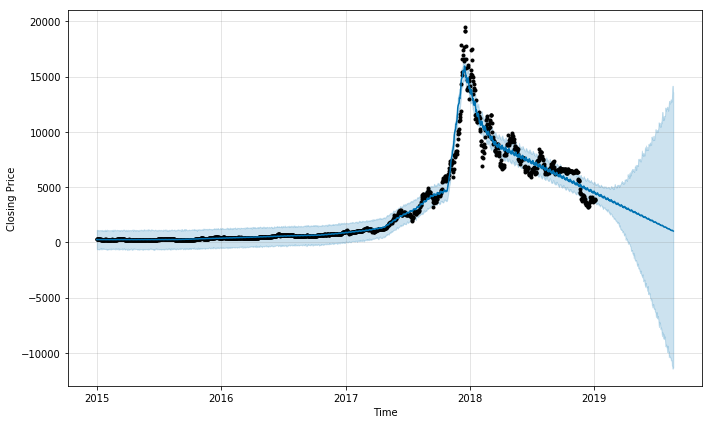

In [40]:
df = pd.DataFrame({'cycle':N,'return':returns,'mape':errors})
optimal_cycle = df[df['mape']<20]
display(optimal_cycle)

df = bitcoin_info[['Date','bt_Close']].copy()
df.columns = ['ds','y']
generateReportForCycle(df,10,'2019-5-31',debug='True')

In [50]:
# this method Return_Dates is copied from medium Yin-Ta Pan
from datetime import datetime
def Return_Dates(forecast,data,cycle,cycle_name = 'custom',time_name = 'ds'):
    high = forecast.iloc[:cycle,]
    high = high[high[cycle_name]==max(high[cycle_name])][time_name]
    high = datetime.strptime(str(high.values[0])[:10],"%Y-%m-%d")
    low = forecast.iloc[:cycle,]
    low = low[low[cycle_name]==min(low[cycle_name])][time_name]
    low = datetime.strptime(str(low.values[0])[:10],"%Y-%m-%d")
    end_dt = pd.to_datetime(data['Date'].iloc[0],format='%Y-%m-%d')
    
    find_list = data['Date'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d'))[::-1]
    
    # Finding selling and buying dates with loop
    sell_dt = []
    sell_dt.append(high)
    # Looking for new cycle until it goes beyond the last date in stock_data
    while high<end_dt:
        high = high+timedelta(days=cycle)
        #dif = (find_list-high).iloc[0].days
        #high = find_list[abs(dif)==min(abs(dif))].iloc[0] # In order to avoid the non-trading dates
        sell_dt.append(high)
    buy_dt = []
    buy_dt.append(low)
    # Looking for new cycle until it goes beyond the last date in stock_data
    while low<end_dt:
        low = low+timedelta(days=cycle)
        #dif = (find_list-low).days
        #low = find_list[abs(dif)==min(abs(dif))][0] # In order to avoid the non-trading dates
        buy_dt.append(low)
    if buy_dt[0] > sell_dt[0]:
        sell_dt = sell_dt[1:]
    buy_dt = buy_dt[:-1]
    sell_dt = sell_dt[:-1]
    return [buy_dt,sell_dt]

#creates 2d array of dates to trade(buy(k=0) or sell(k=1)) and price given an array of 2d arrays
def generateBuyOrSellOrder(k,order):
    for i in range(0,len(dt_list[k])):
        order.append([dt_list[k][i], np.array(bitcoin_info[bitcoin_info["Date"]==dt_list[k][i]]['bt_Close'])])
    return order

def findProfit(pred_price)

m = Prophet(weekly_seasonality=False,yearly_seasonality=False,daily_seasonality=False)
m.add_seasonality('custom',period=10,fourier_order=8,mode='multiplicative')
m.fit(df)
future = m.make_future_dataframe(periods=len(testing))
forecast = m.predict(future)

In [53]:
testing = df[df['ds'] >= '2019-5-31']
dt_list = Return_Dates(forecast,bitcoin_info,10)
buy_order = []
sell_order = []

buy_order_df = pd.DataFrame(generateBuyOrSellOrder(0,buy_order), columns = ['Buy Date', 'Price'])
sell_order_df = pd.DataFrame(generateBuyOrSellOrder(1,sell_order), columns = ['Sell Date', 'Price']) 
display(buy_order_df.head())
display(sell_order_df.head())


,Buy Date,Price
0,2015-01-09,[290.41]
1,2015-01-19,[214.86]
2,2015-01-29,[233.51]
3,2015-02-08,[223.41]
4,2015-02-18,[236.33]


,Sell Date,Price
0,2015-01-11,[265.66]
1,2015-01-21,[226.9]
2,2015-01-31,[217.46]
3,2015-02-10,[219.84]
4,2015-02-20,[243.78]


[[datetime.datetime(2015, 1, 9, 0, 0), array([290.41])],
 [datetime.datetime(2015, 1, 19, 0, 0), array([214.86])],
 [datetime.datetime(2015, 1, 29, 0, 0), array([233.51])],
 [datetime.datetime(2015, 2, 8, 0, 0), array([223.41])],
 [datetime.datetime(2015, 2, 18, 0, 0), array([236.33])],
 [datetime.datetime(2015, 2, 28, 0, 0), array([254.26])],
 [datetime.datetime(2015, 3, 10, 0, 0), array([291.76])],
 [datetime.datetime(2015, 3, 20, 0, 0), array([261.75])],
 [datetime.datetime(2015, 3, 30, 0, 0), array([247.53])],
 [datetime.datetime(2015, 4, 9, 0, 0), array([243.68])],
 [datetime.datetime(2015, 4, 19, 0, 0), array([222.6])],
 [datetime.datetime(2015, 4, 29, 0, 0), array([225.81])],
 [datetime.datetime(2015, 5, 9, 0, 0), array([241.83])],
 [datetime.datetime(2015, 5, 19, 0, 0), array([231.95])],
 [datetime.datetime(2015, 5, 29, 0, 0), array([237.1])],
 [datetime.datetime(2015, 6, 8, 0, 0), array([228.49])],
 [datetime.datetime(2015, 6, 18, 0, 0), array([249.01])],
 [datetime.datetime(2